### Problem description:
__Source__: Kaggle https://www.kaggle.com/annavictoria/speed-dating-experiment <br>

__Description from Kaggle__: What influences love at first sight? (Or, at least, love in the first four minutes?) This dataset was compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar for their paper Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment.

Data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information. See the Speed Dating Data Key document below for details (link for documentation: https://www.kaggle.com/annavictoria/speed-dating-experiment#Speed%20Dating%20Data%20Key.doc).

__Aims of the project__: 

1) Exploring differences in matching/one-sided positive decision for men and women (what is important for both genders, what are the differences between their declared importance of features i.e. attractiveness, intelligence etc. and real choices);<br>
2) Can we see any patterns in speed dating participants' scoring?<br>
3) Same-race preference for male and female participants - could we notice it in the speed dating dataset?<br>
4) How do participants assess their value on the speed dating market? How does it compare to obtained rating? <br>
5) Do order of meeting matters when it comes to participants' willingness to give positive decision?<br>
6) Does size of speed dating group impact participants' decision? <br>
7) Preparing classification model to predict participant's decision.

__Caveats__: Dataset comprises of young people's choices that volunteered by taking part in the speed dating experiment (in the USA). The results of below analysis does not necessarily expand to whole population of young people looking for a partner. I would be very cautious while generalizing, because the group is very specific and speed dating event might be treated in a different way than any other situation leading to meeting/searching for potential partner.


__Topics__: Exploratory Data Analysis, Statistical Inference, Binary Classification

Sklearn-pandas package is needed:

In [1]:
!pip install sklearn-pandas

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

#loading cmaps used
c_redblue = cm.get_cmap('RdBu')
c_greens = cm.get_cmap('Greens')
c_tab20cr = cm.get_cmap('tab20c_r')

#defining colors
blue = c_redblue(0.7)
blue_d = c_redblue(0.9)
red = c_redblue(0.3)
red_d = c_redblue(0.1)
green = c_greens(0.55)
violet = c_tab20cr(0.35)
orange = c_tab20cr(0.75)

### Importing and understanding data 

In [3]:
speed_df = pd.read_csv('./Speed Dating Data.csv', encoding='iso-8859-1') 

Structure and shape of data:

In [4]:
speed_df.shape

(8378, 195)

In [5]:
speed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


In [6]:
speed_df.iloc[:15,]

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.00,20.00,20.00,20.00,0.00,5.00,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.00,0.00,0.00,40.00,0.00,0.00,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.00,18.00,19.00,18.00,14.00,12.00,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.00,5.00,15.00,40.00,5.00,

We can see that each row corresponds with one date. There were 8378 meetings. Dataset has 195 features. 

### Checking null values

In [7]:
null_val_cols = np.sum(speed_df.isnull())/speed_df.shape[0]
null_val_cols = null_val_cols.sort_values(ascending= False)

In [8]:
sns.set_style("white", {'axes.grid' : False,
                        'axes.edgecolor': '#A9A9A9',
                        'text.color':'#313b40'})

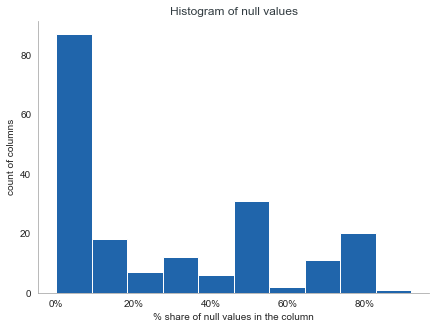

In [9]:
fig, ax = plt.subplots(figsize = (7,5))

ax.hist(null_val_cols, color = blue_d, bins=10)
ax.set_title('Histogram of null values')
ax.set_xlabel('% share of null values in the column')
ax.set_ylabel('count of columns')
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
sns.despine()

plt.show()

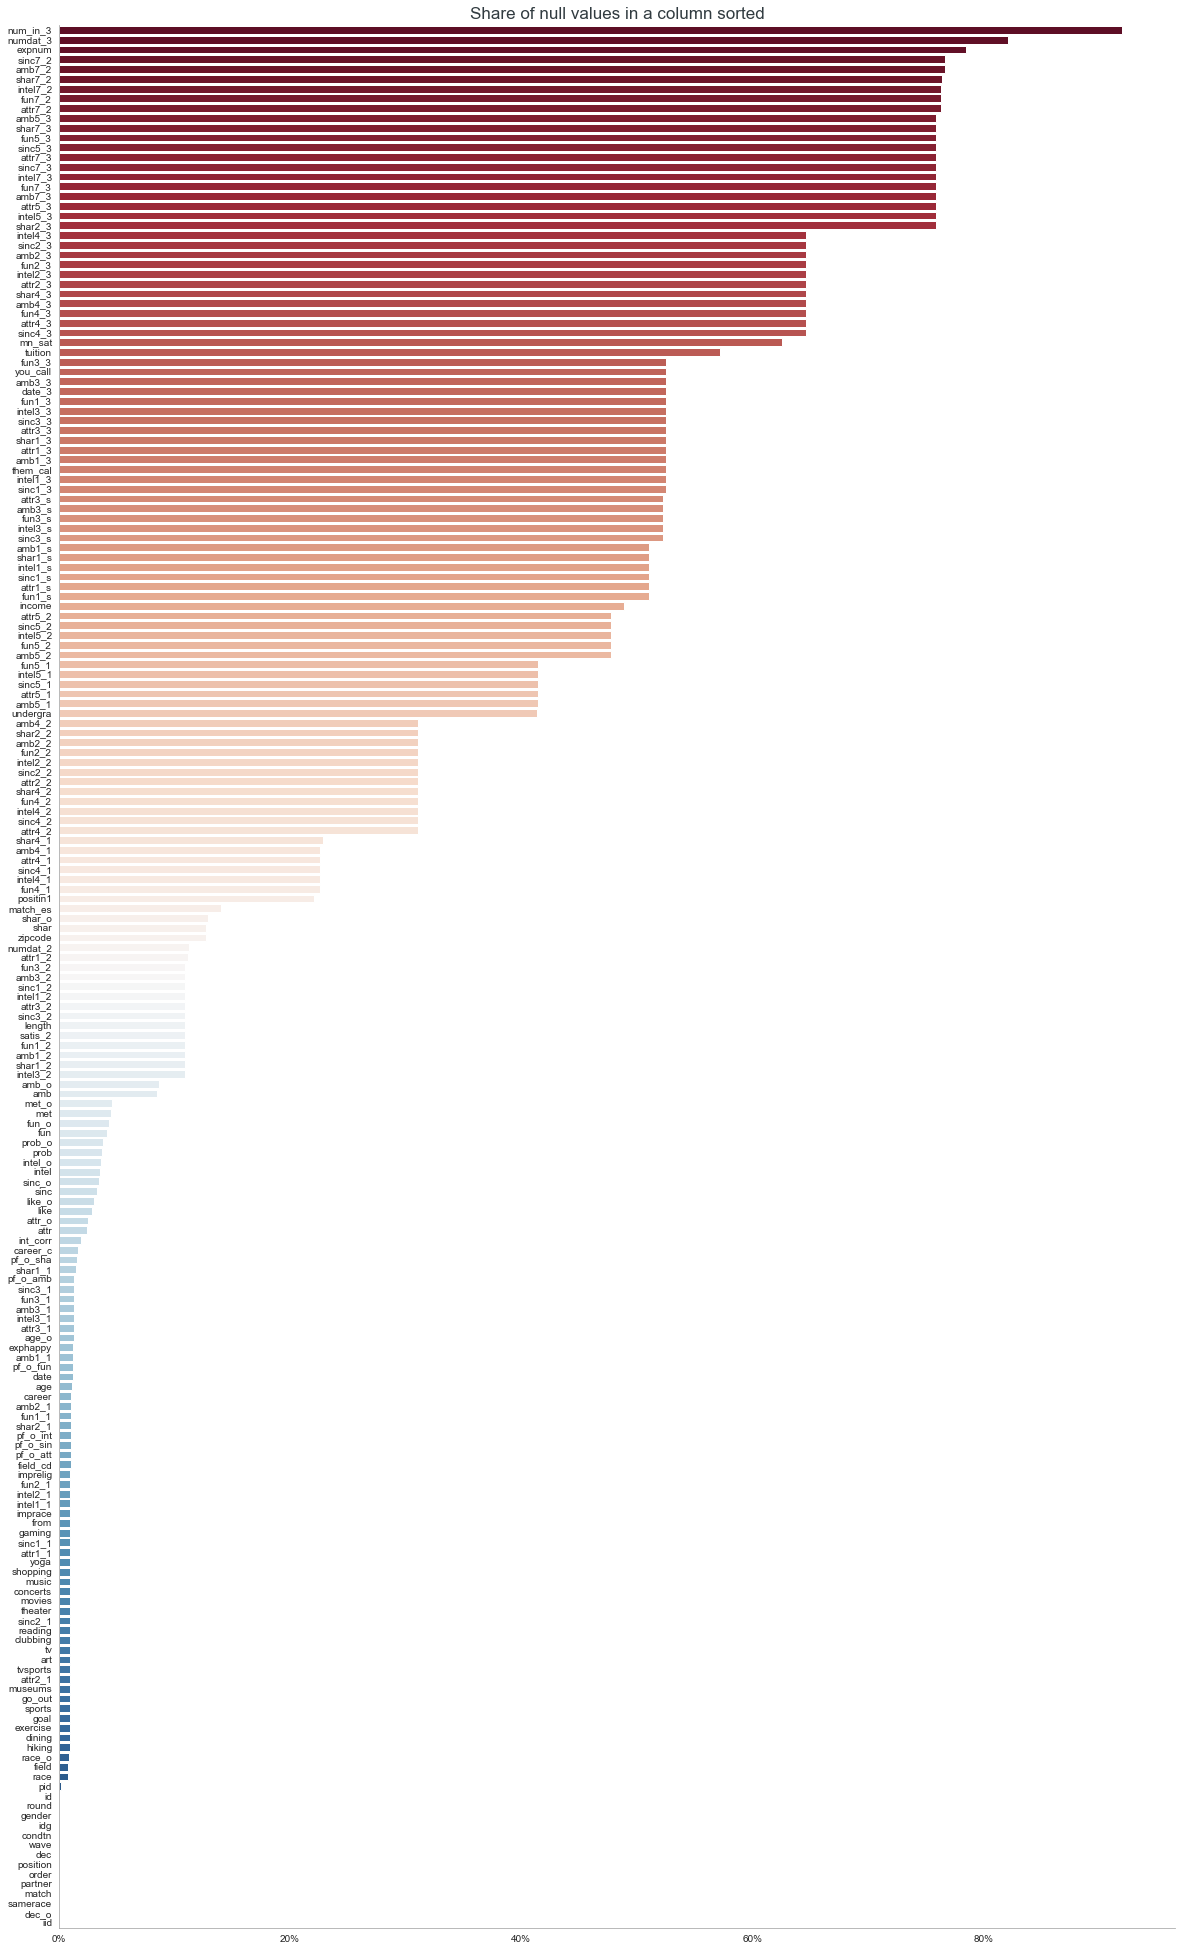

In [10]:
fig = plt.figure(figsize=(20,35))

ax = sns.barplot(x = null_val_cols, y = null_val_cols.index, palette= 'RdBu')
sns.despine()
ax.set_title('Share of null values in a column sorted', fontsize = 17)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.show()

There are some features that have more than 70% of null values. Certainly, they will be not eligible for analyzing with other features that are more complete. It is crucial to compare outcomes from variables with only the same corresponding not null values. I will deal with nans at the later stage.


### Checking number of waves and number of participants in each wave

I will start with filtering single row per participant (as I do not need data on every single date but on participant only). Next I will withdraw number of waves (speed dating events in the experiment) and number of participants in each wave.

In [14]:
speed_df_particip = speed_df.drop_duplicates(subset='iid', keep="last", inplace=False) 
#we do not want to have duplicated info on participants

In [15]:
waves_particip_no = speed_df_particip.groupby('wave').size()
waves_particip_no

wave
1     20
2     35
3     20
4     36
5     19
6     10
7     32
8     20
9     40
10    18
11    42
12    28
13    19
14    38
15    37
16    14
17    24
18    12
19    30
20    13
21    44
dtype: int64

There were 21 speed dating events, each event had different number of participants.

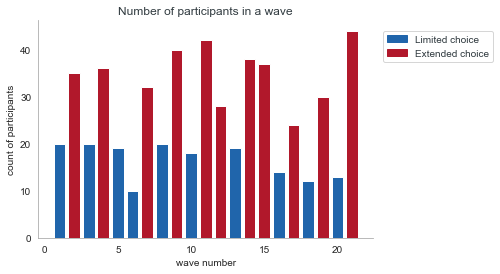

In [16]:
fig, ax = plt.subplots(figsize = (6,4))

#creating color_map based on condtn feature values (1 - limited choice, 2 - extended choice)
wave_condtn = speed_df.drop_duplicates(subset='wave', inplace=False).loc[:,['wave','condtn']].set_index('wave')

color_mapper = {1:blue_d, 
                2:red_d}

colors_mapped = wave_condtn['condtn'].map(color_mapper).values

#generating barplot:
ax.bar(x = waves_particip_no.index, 
       height = waves_particip_no, 
       color = colors_mapped)

#plotting legend:
red_patch = mpatches.Patch(color = blue_d, label='Limited choice')
blue_patch = mpatches.Patch(color = red_d, label='Extended choice')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.03, .95), loc=0, borderaxespad=0.)

#setting title and labels:
ax.set_title('Number of participants in a wave')
ax.set_xlabel('wave number')
ax.set_ylabel('count of participants')

sns.despine()
plt.show()

The experiment was prepared, so that waves had different number of participants (i.e. participants had extensive or limited choice of potential date partner). This condition was encoded with *'condtn'* feature. In the graph above I used it to color each bar in the bar chart. We can see that 50% of waves had limited choice and 50% extended. 

========================================================================================================================

### Data preprocessing: scaling answers on preferences

From documentation:<br>
*"Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important)<br>
Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100."*

I will scale waves 6-9: all of the points from each moment of gathering answers will be summed up and points for each individual preference will be divided by the sum of all points for each participant. This way all of the points will sum up to 100.

Please note that some features were intended to be on a 1-10 scale for all participants (I will not transform them).<br>
Features to be scaled (in accordance with documentation) end with suffix: 1_1, 2_1, 4_1, 1_2, 1_3 


Additional note: while analysing dataset I found out that some other features (and also for other waves than 6-9) have mixed scales (either 0-10 points per feature or 100 points to distribute). I decided to scale all of mixed features to a distribution of 100 points to guarantee consistency in the analysis.

In [17]:
def scaling_preferences(speed_df, var_name_prefixes, var_name_endings = []):
    names = var_name_prefixes
    endings = var_name_endings
    
    wave_mask = (speed_df.loc[:,'wave'] >=0) & (speed_df.loc[:,'wave'] <=22)
    speed_df_c = speed_df.copy()
    
    for ending in endings:
        col_names = []
        for name in names:
            col_names.append(name + ending)

        preferences_df = speed_df_c.loc[wave_mask,col_names]
        col_sum = np.sum(preferences_df,axis=1) #col_sum per each observation (vectorized)

        preferences_scaled = np.asarray(preferences_df)/np.asarray(col_sum).reshape(-1,1)*100 #broadcasting used (converting to np.array and reshaping was necessary)
        speed_df_c.loc[wave_mask,col_names] = preferences_scaled

    return speed_df_c



Scaling both data frames: participants df and dates df

In [19]:
speed_df = scaling_preferences(speed_df,
                               ['attr','sinc','intel','fun','amb','shar'],
                               ['1_1','2_1','4_1','1_2','1_3','1_s'])

speed_df_particip = scaling_preferences(speed_df_particip, 
                                        ['attr','sinc','intel','fun','amb','shar'],
                                        ['1_1','2_1','4_1','1_2','1_3','1_s'])

### Participants' profiles

Before analysing participants'choices and preferences it would be beneficial to gain some insight into participants' profiles: 

1) What is the field of study of participants? <br>
2) Their Age, <br>
3) Race, <br>
4) Their goals while coming to speed dating event, <br>
5) Their interest and differences between men and women

To facilitate this analysis I will work on filtered entries with data about participants to get info about participants only (and not about each date)  - namely on "speed_df_particip" data frame

#### Race of participants

In [20]:
def get_gender_race(speed_df):
    
    speed_df_c = speed_df.copy()
    gender_mapper = {0:'Female',
                     1:'Male'}
    
    
    race_mapper = {1:'Black/African American',
                   2:'European/Caucasian-American',
                   3:'Latino/Hispanic American',
                   4:'Asian/Pacific Islander/Asian-American',
                   5:'Native American',
                   6:'Other'}

    speed_df_c['race_dc'] = speed_df_c['race'].map(lambda x: x if np.isnan(x) else race_mapper[x])
    speed_df_c['gender_dc'] = speed_df_c['gender'].map(lambda x: x if np.isnan(x) else gender_mapper[x])
    
    return speed_df_c

In [21]:
speed_df_particip = get_gender_race(speed_df_particip)
speed_df = get_gender_race(speed_df)

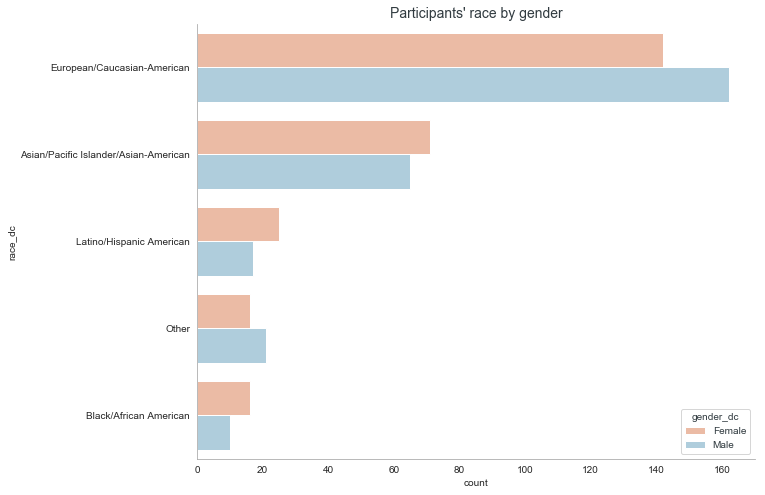

,race_dc
European/Caucasian-American,304
Asian/Pacific Islander/Asian-American,136
Latino/Hispanic American,42
Other,37
Black/African American,26
Number of null values,63


In [22]:
fig = plt.figure(figsize=(10,8))

ax = sns.countplot(y = 'race_dc',
                   hue = 'gender_dc',
                   data = speed_df_particip,
                   palette = 'RdBu',
                   order = speed_df_particip['race_dc'].value_counts().index)

ax.set_title('Participants\' race by gender', fontsize = 14)
sns.despine()
plt.show()

race_tab = speed_df_particip['race_dc'].value_counts()
race_tab['Number of null values'] = sum(speed_df.loc[:,'race'].isnull())
pd.DataFrame(race_tab)

#### Age of participants

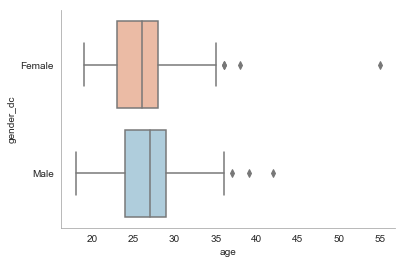

In [23]:
sns.boxplot(y ='gender_dc', 
            x = 'age', 
            data = speed_df_particip,
            orient = 'h',
            palette= 'RdBu')

sns.despine()
plt.show()

Participants are rather young people: median age for male equals 27 years and 26 for female participants. Vast majority of participants are under 35.

#### Field of study

In [24]:
def get_study_field(speed_df_particip):
    
    speed_df_particip_c = speed_df_particip.copy()
    
    study_mapper = {1:'Law',  
                    2:'Math',
                    3:'Social Science, Psychologist',
                    4:'Medical Science, Pharmaceuticals, and Bio Tech', 
                    5:'Engineering',
                    6:'English/Creative Writing/ Journalism', 
                    7:'History/Religion/Philosophy', 
                    8:'Business/Econ/Finance',
                    9:'Education, Academia', 
                    10:'Biological Sciences/Chemistry/Physics',
                    11:'Social Work', 
                    12:'Undergrad/undecided', 
                    13:'Political Science/International Affairs', 
                    14:'Film',
                    15:'Fine Arts/Arts Administration',
                    16:'Languages',
                    17:'Architecture',
                    18:'Other'}
    
    speed_df_particip_c['field_dc'] = speed_df_particip_c['field_cd'].map(lambda x: x if np.isnan(x) else study_mapper[x])
    
    #ponizej tabelka zrezygnowalem poki co
    #field_of_study = pd.DataFrame(speed_df_particip.groupby('gender')['field_dc'].value_counts())
    #field_of_study = field_of_study.unstack(level=0)
    #field_of_study.columns = field_of_study.columns.droplevel(0)
    
    return speed_df_particip_c

In [25]:
def plt_study_field(speed_df_particip):
    
    speed_df_particip = get_study_field(speed_df_particip)

    fig = plt.figure(figsize=(12,12))
    ax = sns.countplot(y = 'field_dc',
                       hue = 'gender',
                       data = speed_df_particip, 
                       palette = 'RdBu',
                       order = speed_df_particip['field_dc'].value_counts().index)

    ax.set_title('Participants\' field of study by gender', fontsize = 14)
    legend = plt.legend()
    legend.get_texts()[0].set_text('Female')
    legend.get_texts()[1].set_text('Male')
    sns.despine()
    plt.show()
    return print('Number of null values equals: {}'.format(sum(np.any(speed_df_particip.loc[:,['gender','field_dc']].isnull(),axis=1))))

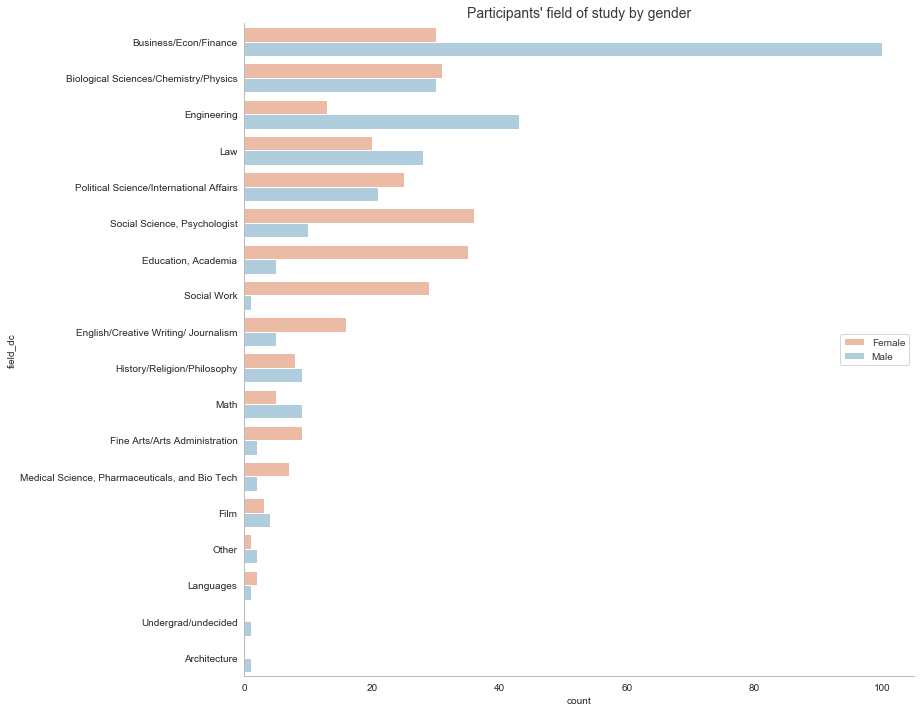

Number of null values equals: 7


In [26]:
plt_study_field(speed_df_particip)

There is very strong representation of business/finance students/alumni in the speed dating experiment. We can also see that there are much more men than women in this field of study. However, other social sciences like psychology, journalism, social work, education, political science are dominated by women.

#### Goals of participants
Let's investigate the goals of participants in the speed dating experiment

In [27]:
goal_tab = pd.crosstab(index = speed_df_particip['goal'],columns = speed_df_particip['gender'])

goal_tab_norm = pd.crosstab(index = speed_df_particip['goal'],columns = speed_df_particip['gender'], normalize = 'columns')
goal_tab_norm.columns = ['Female','Male']
goal_tab_norm.index = ['Seemed like a fun night out',
                         'To meet new people',
                         'To get a date',
                         'Looking for a serious relationship',
                         'To say I did it',
                         'Other']

goal_tab_norm.style.format('{:.0%}')

,Female,Male
Seemed like a fun night out,43%,41%
To meet new people,37%,32%
To get a date,5%,10%
Looking for a serious relationship,3%,5%
To say I did it,7%,6%
Other,5%,6%


In [28]:
chi2, p, dof, ex = stats.chi2_contingency(goal_tab)

results = pd.Series()
results['CHI2_stat'] = chi2
results['p-value'] = p
results

CHI2_stat    6.381533
p-value      0.270844
dtype: float64

Both male and female participants came mostly to have a fun night out and/or meet new people, and not necessarily to get a date or start a serious relationship.

It looked like men were more inclined to get a date than women, but after testing for significance (chi-square test of independence of variables in a contingency table) we have to reject the null hypothesis and conclude that there is no evidence that there is any difference between genders. 

#### Going out and dating:

In [29]:
def plt_go_out_dating(speed_df_particip):
    
    speed_df_particip_c = speed_df_particip.copy()
    
    #decoding number to names (for both date and go_out variables)
    names_mapper = {
                    1: 'Several times a week',
                    2: 'Twice a week',
                    3: 'Once a week',
                    4: 'Twice a month',
                    5: 'Once a month',
                    6: 'Several times a year',
                    7: 'Almost never'}
    
    dating_going_out_tab = pd.crosstab(speed_df_particip_c['date'],speed_df_particip_c['go_out'], margins = False)
    dating_going_out_tab.index = dating_going_out_tab.index.map(lambda x: names_mapper[x])
    dating_going_out_tab.columns = dating_going_out_tab.columns.map(lambda x: names_mapper[x])
    
    #plotting:
    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_title('Heatmap of participants\' going out and dating frequency')
    sns.heatmap(dating_going_out_tab, annot = True, linewidths =1.5,cmap = 'RdBu', ax = ax)
    ax.invert_xaxis()
    
    fig, axs = plt.subplots(1,2,figsize=(11,4))
    axs = axs.ravel()
   
    sns.countplot(speed_df_particip_c['go_out'], ax = axs[0], color = violet)
    axs[0].invert_xaxis()
    axs[0].set_title('Frequency of participants\' dating')
    axs[0].set_xticklabels(['Several times a week',
                        'Twice a week', 
                        'Once a week',
                        'Twice a month',
                        'Once a month',
                        'Several times a year',
                        'Almost never'])
    plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=70 )
    
    
    sns.countplot(speed_df_particip_c['date'], ax = axs[1], color = orange)
    axs[1].invert_xaxis()
    axs[1].set_title('Frequency of participants\' going out')
    axs[1].set_xticklabels(['Several times a week',
                        'Twice a week', 
                        'Once a week',
                        'Twice a month',
                        'Once a month',
                        'Several times a year',
                        'Almost never'])
    plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=70 )
    sns.despine()
    
    return plt.show()

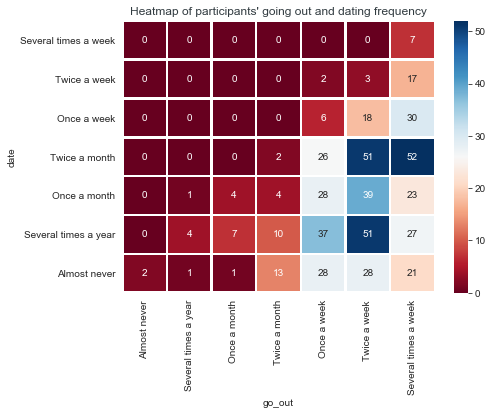

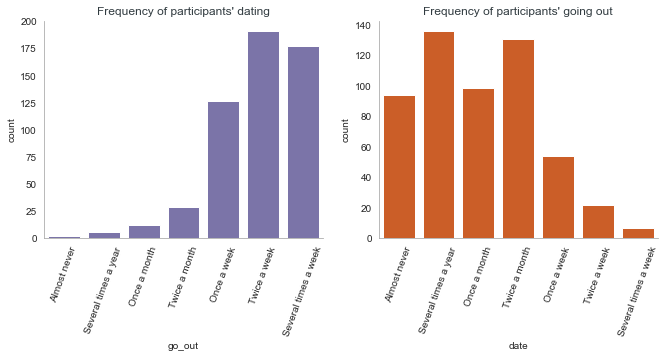

In [30]:
plt_go_out_dating(speed_df_particip)

We can notice that most of the participants are sociable: almost no one goes out less than twice a month. Going out twice a week is the mode. When it comes to dating - obviously the more often the person goes out the more dates he/she has, but here we can see higher dispersion: there are people who almost never dates and some that do it twice a week.  

In [32]:
def plot_interests(speed_df_particip):
    variables = ['sports',
                'exercise',
                'dining',
                'museums',
                'art',
                'hiking',
                'gaming',
                'clubbing',
                'reading',
                'tv',
                'theater',
                'movies',
                'concerts',
                'music',
                'shopping',
                'yoga']

    speed_df_melted = pd.melt(speed_df_particip,id_vars=['gender_dc'], value_vars= variables)
    
    means_glob = speed_df_melted.groupby(['variable']).agg('mean')
    means = speed_df_melted.groupby(['gender_dc','variable']).agg(['mean','size'])
    means = means.unstack(level=0)

    means.columns = means.columns.droplevel()
    means.columns = ['_'.join(col) for col in means.columns]
    
    means['global_mean'] = means_glob.values
    means['diff'] = np.abs(means['mean_Female'] - means['mean_Male'])
    means_ord = means.sort_values(by='global_mean')
    
    plt.figure(figsize=(9,8))
    idx_range = range(1,len(means_ord)+1)
    
   
    plt.hlines(y = idx_range, xmax = means_ord['mean_Female'], xmin = means_ord['mean_Male'], color = 'grey')
    plt.scatter(y = idx_range, x = means_ord['mean_Female'], c = red)
    plt.scatter(y = idx_range, x = means_ord['mean_Male'], c = blue)
    plt.xlim(0,10)
    plt.yticks(idx_range, means_ord.index)
    plt.xlabel('Points')
    plt.ylabel('Interest category')
    plt.title('Interest scores differences by gender (the higher the more interesting)')
    
    blue_patch = mpatches.Patch(color = blue, label='Male')
    red_patch = mpatches.Patch(color= red, label='Female')
    plt.legend(handles=[blue_patch, red_patch])

    sns.despine()
    
    return plt.show()
    

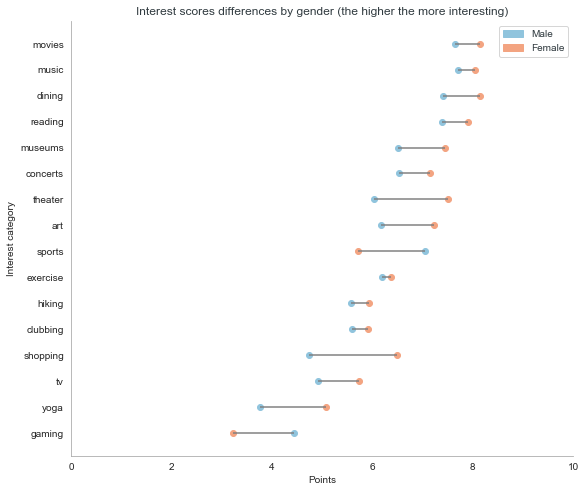

In [33]:
plot_interests(speed_df_particip)

From the chart above we can see that:<br>

1) for both genders: movies, music, dining and reading are the most interesting activities from hobbies listed above. <br>
2) women are more enthusiastic (higher overall scores for most of the categories)<br>
3) biggest differences between men and women are: attitude towards shopping, theater, yoga (women are more interested in them) and sports (for men sports are more interesting)

### How happy will participant be during speed dating ?

In [34]:
#checking nulls:
sum(speed_df_particip['exphappy'].isnull())

8

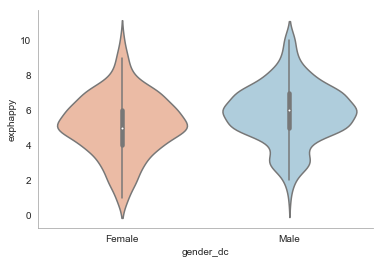

In [35]:
sns.violinplot(y = 'exphappy', x='gender_dc', data = speed_df_particip, palette='RdBu')
sns.despine()
plt.show()

In general, participants do not expect anything spectacular from speed dating event: median score for male is 6/10 and for female is 5/10, (the higher the score the more happy participant expect to be during speed dating). Male participants are a bit more optimistic when it comes to their assessed satisfaction from speed dating event.

### Self-esteem vs actual scores received during speed dating

Are people on average overly optimistic/pessimistic while assesing scores that they presume to get?

In [49]:
def attributes_comp(speed_df_particip):

    speed_df_attr = speed_df_particip.copy()
    
    #attribute names to withdraw from dataset:
    attr_selfestim = ['attr3_2','sinc3_2','intel3_2','fun3_2','amb3_2']
    attr_rated = ['attr','sinc','intel','fun','amb']

    attr_merged = attr_selfestim + attr_rated

    names_mapper = { 
                    'attr3_2':'attractive_self_estimate',
                    'sinc3_2':'sincere_self_estimate',
                    'intel3_2':'intelligent_self_estimate',
                    'fun3_2':'fun_self_estimate',
                    'amb3_2':'ambition_self_estimate',

                    'attr':'attractive_rated',
                    'sinc':'sincere_rated',
                    'intel':'intelligent_rated',
                    'fun':'fun_rated',
                    'amb':'ambition_rated'
                    }

    speed_df_attr = speed_df_attr.loc[:,['gender']+attr_merged]
    speed_df_attr.dropna(inplace=True, axis = 0)
    
    #preparing grid for subplots:
    fig, axs = plt.subplots(3,2,figsize = (14,10))
    axs = axs.ravel()
    st = fig.suptitle('Distribution of self estimated rating (from questionnaire: How do you think you measure up?) vs. actual ratings obtained',
                      fontsize=14)

    attribute_names = ['attractive', 'sincere', 'intelligent', 'fun', 'ambition']
    
    #iterate over rated attributes:
    for idx, col in enumerate(attr_rated):
        
        #choosing columns with self estimated rating and actual rating  
        selfest_vs_rated = speed_df_attr.select(lambda x: x.startswith(col), axis=1)
        selfest_vs_rated.columns = selfest_vs_rated.columns.map(lambda x: names_mapper[x])
        #plotting distribution of ratings
        sns.boxplot(data = selfest_vs_rated, palette = 'tab20c_r', orient = 'h', ax = axs[idx])
        axs[idx].set_title(attribute_names[idx])
        plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=1.5)

    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    
    return plt.show()

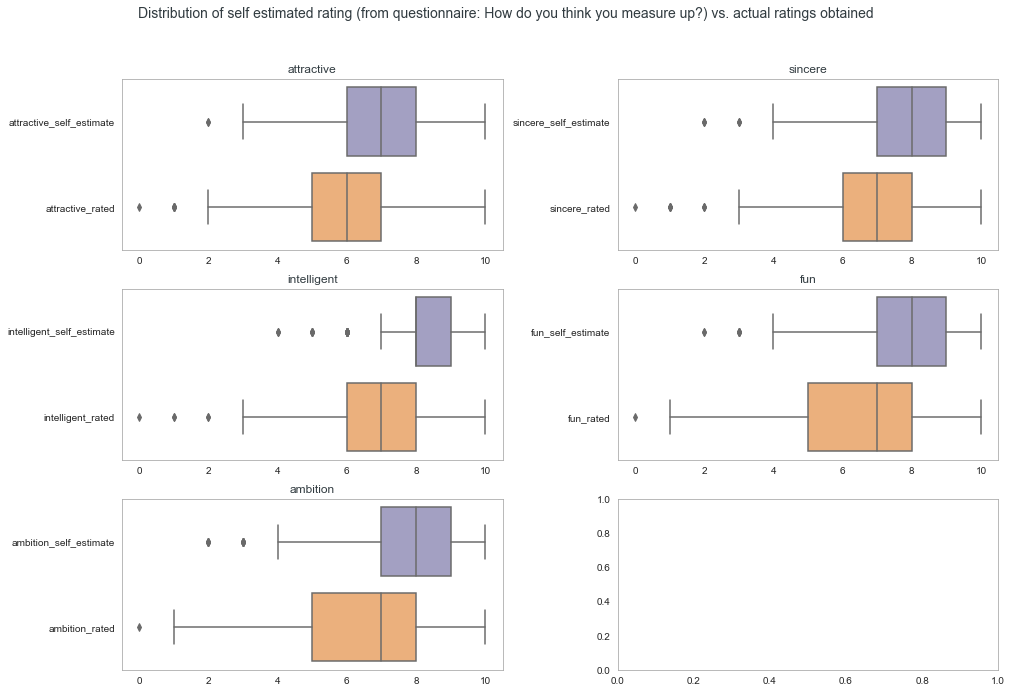

In [50]:
attributes_comp(speed_df_particip)

There is a considerably wide gap between expected rating and rating obtained: generally speaking, people are less critical to themselves than to others and what is the most interesting for me: almost no one finds himself not intelligent.

### Overview of participants decisions and matches

In [51]:
print('Percentage of positve decisions (i.e. participants who wanted to meet his/her speed dating partner once again: {0:.1%}'.format(speed_df['dec'].mean()))

Percentage of positve decisions (i.e. participants who wanted to meet his/her speed dating partner once again: 42.0%


In [52]:
def plt_decision_dist(speed_df):
    
    #getting % of yes decision per participant:
    decisions_dist = speed_df.groupby('iid')['dec'].sum()/speed_df.groupby('iid')['round'].size()
    
   
    #plotting
    plt.hist(decisions_dist, bins = np.linspace(0,1,11), color=violet)
    sns.despine()
    blue_d_patch = mpatches.Patch(color= violet, label='number of participants')
    plt.legend(handles=[blue_d_patch])
    plt.title('Distribution of %yes decisions among participants')
    
    return plt.show()

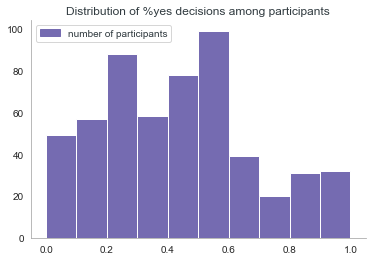

In [53]:
plt_decision_dist(speed_df)

From the graph above we can observe that the value that appeared most often (mode) was 50% - 60% of yes decisions.
We can also see that there were some people who were maximizing their chances of match by giving as much as 90% - 100% of positive decisions.<br>

__But what about matches?__:<br>
First I will show percentage meetings that were concluded with match and show the % of mismatch.<br>
Later I will filter out people who did not give any positive decision (did not give any chance for a match) and analyse matches in this subgroup.


In [54]:
print('Percentage of matches (match occurs when participant and his partner both checked \'Yes\' decision: {0:.1%}'.format(speed_df['match'].mean()))

Percentage of matches (match occurs when participant and his partner both checked 'Yes' decision: 16.5%


In [55]:
print('Percentage of mismatch (i.e. how many positive decisions were one-sided): {0:.1%}'.format(sum((speed_df['dec'] == 1) & (speed_df['match'] == 0)) / sum(speed_df['dec'] == 1)))

Percentage of mismatch (i.e. how many positive decisions were one-sided): 60.8%


In [56]:
def match_dist(speed_df):

    speed_df_iid = speed_df.groupby('iid')
    speed_pos_dec = speed_df_iid.filter(lambda x: x['dec'].sum() > 0) #filtering out people who did not give any positive decision
    speed_match = speed_pos_dec.groupby('iid')['match'].sum()/speed_pos_dec.groupby('iid')['round'].size()
    
    plt.hist(speed_match, color = violet)
    sns.despine()
    blue_d_patch = mpatches.Patch(color= violet, label='number of participants')
    plt.legend(handles=[blue_d_patch])
    plt.title('Distribution of %matches among participants')
    plt.show()
    
    return  speed_match 

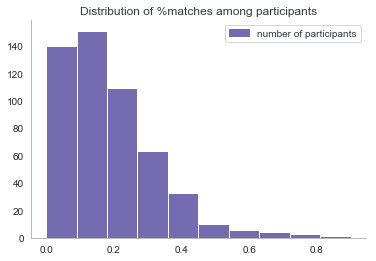

In [57]:
speed_all_matches = match_dist(speed_df)

The largest group of participants have converted between 10-20% of their meetings into matches (what translates to about 1-2 matches per speed dating event). We can see that there were even some people who matched during 80-90% of all meetings!<br> Now let's see how many people did not have any match, although they give at least 1 positive decision. 

In [58]:
speed_no_match = speed_all_matches.loc[speed_all_matches == 0]

In [59]:
print('Percentage of forever alones: {0:.1%}'.format(len(speed_no_match) / len(speed_all_matches)))

Percentage of forever alones: 13.1%


--------------------

### How well did people guess whether they would be invited?

In [62]:
def dec_vs_prob(speed_df):
    
    speed_df['prob_bins'] = pd.cut(speed_df['prob'], bins = np.arange(0,11,1),include_lowest=True)
    prob_dec_tab = pd.crosstab(index = speed_df['prob_bins'], columns = speed_df['dec_o'], normalize='index')
    prob_dec_tab['sample_size'] = speed_df['prob_bins'].value_counts().sort_index()    
    
    mean_prob_dec = speed_df.groupby('dec_o')['prob'].agg('mean')

    
    fig, ax =  plt.subplots(figsize=(10,5))

    
   #plotting:
    prob_dec_tab.loc[:,[1,0]].plot(kind = 'bar', stacked = "True", color = [blue_d,red_d], ax = ax)
    ax.set_title('% of actual \'yes\'/\'no\' decisions (y-axis) vs.\n' 
                    'chance of \'yes\' decisions assessed by participants (x-axis) ', fontsize = 14)
    
    ax.set_xlabel('self estimated chance of \'yes\' decision on 0-10 scale (groupped in bins)', fontsize = 12)
    ax.set_ylabel('% of actual \'yes\'/\'no\' decisions', fontsize  =12)

    blue_patch = mpatches.Patch(color = blue_d, label='\'yes\' decision')
    red_patch = mpatches.Patch(color= red_d, label='\'no\' decision')
    ax.legend(handles=[blue_patch, red_patch])
    sns.despine()
    
    plt.show()  
    
    
    return prob_dec_tab, mean_prob_dec
    

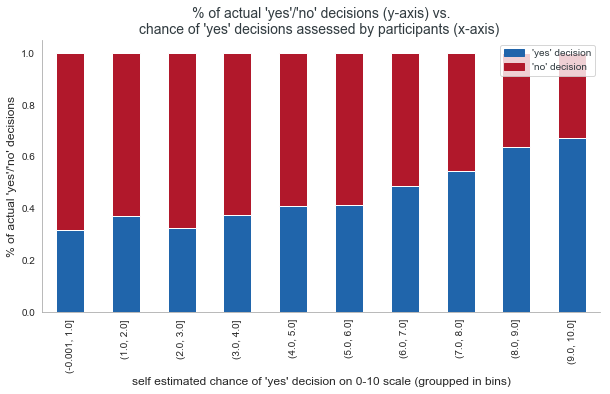

dec_o
0    4.930900
1    5.580134
Name: prob, dtype: float64

In [63]:
prob_dec_tab, mean_prob_dec = dec_vs_prob(speed_df)
mean_prob_dec

From the graph above we can see that participants had some problems with assessing their chances (i.e. 'yes' decision of their dating partners). Even when they were almost certain (self-estimated chance at the highest levels of 9 - 10) that they will be invited, only 67% of such people actually obtained positive decision. Similarly for people that were almost certain that they will not be invited (chance at the level of 0-1): only 68% were right.

### Did race of paritcipants impact actual decision?

In [64]:
pd.DataFrame(speed_df_particip.groupby('gender_dc')['imprace'].mean())

,imprace
gender_dc,
Female,4.115242
Male,3.360000


In the table above we can see average importance of same race for participants (on a 0-10 scale). Women declare that same race is a bit more important for them than for men, however it is not very significant factor (only 4.1/10). 

Graph below illustrates distribution of reported importance of same race 

In [65]:
def plt_samerace_survey_importance(speed_df_particip):
    fig, ax = plt.subplots(figsize=(7,5))
    sns.boxplot(x = 'gender_dc', y = 'imprace', data = speed_df_particip, palette= 'RdBu', ax = ax)
    sns.despine()
    ax.set_ylabel('Self reported importance of same race')
    ax.set_xlabel('Gender')
    ax.set_title('Distribution of reported importance of same religion')
    return plt.show()

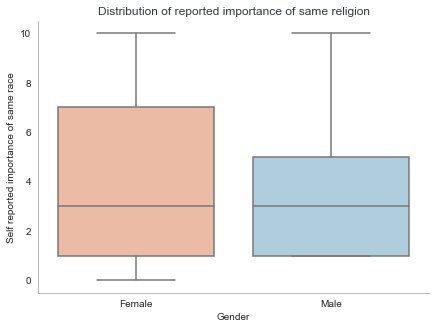

In [66]:
plt_samerace_survey_importance(speed_df_particip)

Now let's check whether and how the stated importance of same race factor influenced actual decisions of male and female participants. 

In [67]:
def plt_samerace_act_importance(speed_df):    
    
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(x = 'gender_dc', y = 'dec', hue='samerace', data = speed_df, palette= 'tab20c_r', ax = ax)

    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+p.get_width()/2.5, p.get_height()/1.2))


    ax.set(yticklabels=[])
    ax.set_ylabel('')
    ax.set_ylim([0,0.6])
    ax.set_title('% of yes decisions for same and different race split by gender',fontsize = 14)

    legend = ax.legend()
    legend.get_texts()[0].set_text('Different race')
    legend.get_texts()[1].set_text('Same race')
    ax.set_xlabel('Gender')
    sns.despine(left='False')
    plt.show()
    return print('Number of null values equals: {}'.format(sum(np.any(speed_df.loc[:,['samerace','dec']].isnull(),axis=1))))

In [68]:
def test_ind_chisq(speed_df):
    
    results= {}
    gender_lst = ['Female','Male']
    speed_df_grouped = speed_df.groupby('gender_dc')
    
    
    for gender in gender_lst:
        
        speed_df_gender = speed_df_grouped.get_group(gender)
        dec_race_tab = pd.crosstab(speed_df_gender['dec'],speed_df_gender['samerace'],margins=False)
        
        chi2, p, __, __ = stats.chi2_contingency(dec_race_tab)
        results[gender] = [chi2,p]
        
    return pd.DataFrame(results, index = ['chisq_stat','p-value'])

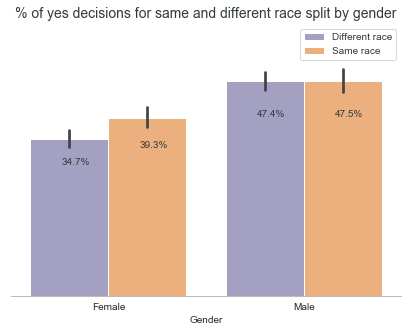

Number of null values equals: 0


In [69]:
plt_samerace_act_importance(speed_df)

In [70]:
test_ind_chisq(speed_df)

,Female,Male
chisq_stat,8.958416,0.000153
p-value,0.002762,0.990145


Female during the speed dating experiment tended to choose same race partners more often (the average difference in %of yes decisions for female was 4.6 pp. higher than for different race, the difference is statistically significant). Male participants' decisions, however, were not influenced by partner's race. 

We can also see that in general men were less choosy than women and gave more positive decisions.

### % of positive decision given attractiveness score:

In [71]:
def dec_vs_attr(speed_df):

    speed_df = speed_df.loc[speed_df['attr'].notnull(),:] #dropping nans from attr column (dec column has no nan values)  

    speed_df['attr_q5'] = pd.qcut(speed_df['attr'],q=10,duplicates='drop')
    return speed_df.groupby(['gender_dc','attr_q5'])['dec'].agg(['mean','size'])


In [72]:
dec_vs_attr(speed_df)

C:\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


mean  size
gender_dc attr_q5                      
Female    (-0.001, 4.0]  0.102236   939
          (4.0, 5.0]     0.220030   659
          (5.0, 6.0]     0.308376   788
          (6.0, 7.0]     0.513889   792
          (7.0, 8.0]     0.649123   570
          (8.0, 9.0]     0.748879   223
          (9.0, 10.0]    0.866071   112
Male      (-0.001, 4.0]  0.048043   562
          (4.0, 5.0]     0.226290   601
          (5.0, 6.0]     0.388506   870
          (6.0, 7.0]     0.596980   861
          (7.0, 8.0]     0.783133   664
          (8.0, 9.0]     0.833333   318
          (9.0, 10.0]    0.838710   217

It can be easily observed that higher attractiveness is positively correlated with rate of positive decisions both for men and women. I will investigate this also in more detail in the later section.

### Halo effect - do people tend to score attractive partners higher in other aspects than attractiveness?

Halo effect is a well documented social-psychology phenomenon that causes people to be biased in their judgments by transferring their feelings about one attribute of something to other, unrelated, attributes. We can see whether it is the case here, in speed dating experiment:

In [73]:
def halo_effect(speed_df):
        
    speed_df['attr_q5'] = pd.qcut(speed_df['attr'],q=10,duplicates='drop')
    halo_tab = speed_df.groupby('attr_q5')['sinc','intel','fun','amb','shar'].agg('mean').T
    
    plt.figure(figsize=(10,6))
    sns.heatmap(halo_tab, cmap='RdBu', linewidths=1, annot=True)
    plt.title('Halo effect: how other attributes than attractiveness are\n scored for each attractiveness group', fontsize =14)
    plt.xlabel('Attractiveness score')
    return plt.show()

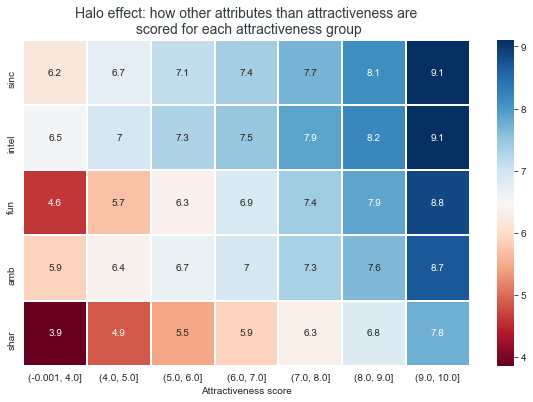

In [74]:
halo_effect(speed_df)

The higher the attractiveness score (bins with scores on the x axis), the higher are scores for all other attributes (see annotations on the heatmap: average score for each attribute and colors: the more blue the higher the score). <br>
This result might support existence of halo effect, bacause for example there is no evidence that attractive people are more sincere (and this is exactly what results from graph above).

### Order of meeting vs. decision

In [75]:
def order_vs_deciosion(speed_df):
    ord_dec = speed_df.groupby('order')['dec'].agg(['mean','size']).reset_index() 
    
    sns.regplot(x = 'order', y ='mean', data = ord_dec, ci =None, color=violet)
    sns.despine()
    plt.show()
    
    
    corr, p_val = stats.spearmanr(ord_dec['order'],ord_dec['mean'])

    return  print('Spearman correlation of order of meeting and percentage of positive decision equals: {:.2f}\n'
                   'with p-value of {:.3f}'.format(corr,p_val))
    
    

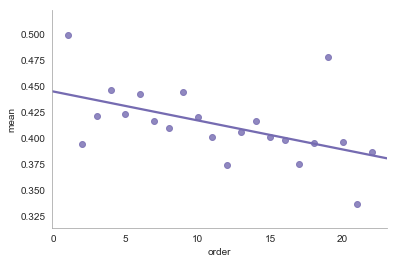

Spearman correlation of order of meeting and percentage of positive decision equals: -0.57
with p-value of 0.006


In [76]:
order_vs_deciosion(speed_df)

The later was the meeting the lower was the share of positive decisions, we can speculate that the longer the speed dating event the more tired participants and less engaged and willing to meet new people.

### Relative importance of attributes - initial survey

Now I will try to investigate which attributes are important for people that took part in this speed dating experiment.<br>
As it was introduced in the previous section, there were 6 attributes to rate: attractive, sincere, intelligent, fun, ambitious, has shared interests (abbreviations: attr, sinc, intel, amb, shar).<br>
At this part of analysis I will show participants preferences as declared by them in the initial survey filled before speed dating event.<br>
At the later stage, I will compare it with actual decisions made during speed dating event.

In [77]:
def attrib_importance_survey(speed_df):

    attributes = ['attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1']

    positive_dec_particip = speed_df.groupby('iid')['dec'].agg(np.sum) > 0 #choosing participants that only have chosen at least 1 person (we want to see their consistency )
    pos_dec_mask = positive_dec_particip

    speed_df_particip = speed_df.drop_duplicates(subset='iid', keep="last", inplace=False).set_index('iid')
    speed_df_particip = speed_df_particip.loc[pos_dec_mask.values,:]

    mean_attr_survey = speed_df_particip.groupby('gender_dc')[attributes].agg('mean')

    speed_df_melted = pd.melt(speed_df_particip,id_vars=['gender_dc'], value_vars= attributes)
    speed_df_melted.dropna(axis=0, inplace = True)

    plt.figure(figsize=(13,10))
    sns.boxplot(x = 'variable', y ='value' , hue = 'gender_dc', data  =  speed_df_melted, palette = 'RdBu')
    plt.hlines(y = speed_df_melted['value'].mean(), xmin = -1, xmax = 10, linestyles = 'dotted', colors= violet, 
               label = 'All features equally important')
    plt.gca().legend()
    sns.despine()
    plt.title('Distribution of features\' importance by gender', fontsize = 13)
    plt.xlabel('Attribute')
    plt.ylabel('Relative importance')
    plt.show()

    return mean_attr_survey



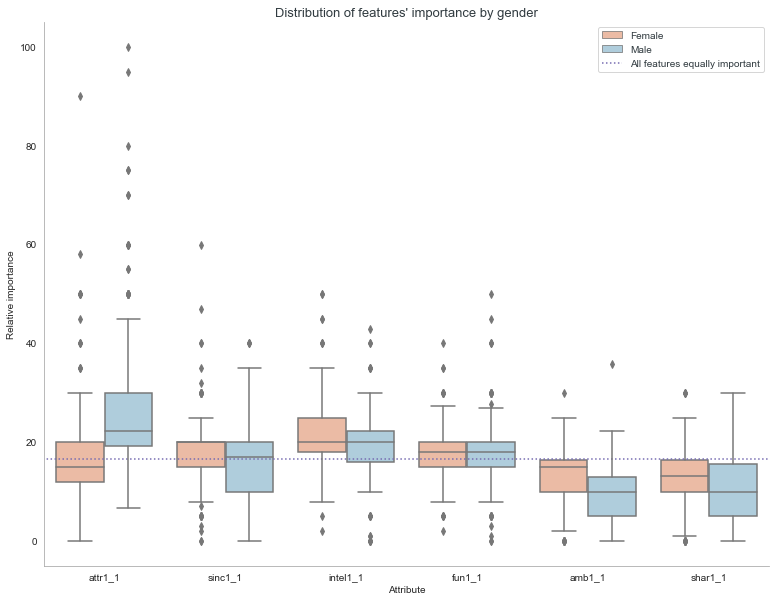

In [78]:
mean_attrib_survey = attrib_importance_survey(speed_df)

In [79]:
print('Mean attribute importance by gender:')
mean_attrib_survey

Mean attribute importance by gender:


,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
gender_dc,,,,,,
Female,17.70959,18.312297,21.033567,17.434207,12.763635,12.798310
Male,27.19302,16.394983,19.368267,17.483288,8.749823,11.025029


Please note that if all attributes were equally important, every attribute would be rated 16.66 (due to the fact, that points distributed among attributes must sum up to 100: 16.66 * 6  = 100)

From the above graph and table results that female are more balanced when it comes to their declared importance of attributes. The most important one is intelligence (avg. of 21.0 points) and the least are ambition and shared interests (both 12.8 points).<br>
When it comes to male participants: attractiveness dominates all other traits: 27.2 points. Least important feature: ambition (only 8.7 points).

Looking at the boxplots, however, we can see that dispersion of attribute importance is quite high, with many extreme values especially in the scoring of attractiveness. 

### How consistent were participants in their stated attribute importances?

First I calculate the correlation between average actual scores of attributes obtained by each participant and percentage of positive decisions obtained. By the same token, I will be able to see how strong were the correlations between each attribute separated and share of positive decisions. <br>

Next, I will sum all correlation coefficients for all attributes and use it as a scaler for each separate correlation so that all correlation coefficients will total 100 points (to guarantee comparability with data from relative importance of attributes in the survey).<br>

At the end, I will compare average importance of each attribute both for men and women from survey to calculated importance resulting from actual decisions.

Idea for this particular analysis comes from Kaggle public kernel (url:https://www.kaggle.com/jph84562/the-ugly-truth-of-people-decisions-in-speed-dating). Code below was produced by myself.

In [80]:
def calc_decision_attr_corr(speed_df):
      
    cols = ['dec_o','attr_o','sinc_o','intel_o','fun_o','amb_o','shar_o']
    
    speed_df_iid = speed_df.groupby('iid')
    speed_pos_dec = speed_df_iid.filter(lambda x: x['dec'].sum() > 0) #filtering out people that did not choose anyone
    pos_dec_idx = speed_pos_dec.index
    
    speed_df_gender_iid = speed_df.loc[pos_dec_idx,:].groupby(['gender_dc','iid'])[cols].agg('mean')

    
    gender = ['Female','Male']
    dec_attribute_corr = {}
    
    #iterating over male and female separately
    for g_idx, g in enumerate(gender):

        gender_df = speed_df_gender_iid.loc[g]
         #calc correlations between all attributes
        gender_corr = gender_df[cols].corr()
         #select correlations between dec_o and other attributes only
        dec_attribute_corr[g] = gender_corr.iloc[0,1:]
        
        #plotting correlations for men and women:
        fig, axs = plt.subplots(2,3, figsize = (12,6))
        axs = axs.ravel() #flattening axes - easier to iterate over them
        colors = [red, blue]
        print('Regression of percentage of yes decisions for each ' + g.lower() + ' against attribute score' ) 
        for i, attr in enumerate(gender_df.columns[1:]):
            plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=1.5)
            sns.regplot(x = 'dec_o' , y = attr, data = gender_df, ax = axs[i], color = colors[g_idx], line_kws = {'color':'grey'})
            sns.despine()
        
        plt.show()
        print('---------------------------------------------------------------------------------------------------------------------------'
              '---------------------------------------------------------------------------------------------------------------------------')    
    dec_attr_corr = pd.DataFrame(dec_attribute_corr).T
    dec_attr_corr_sum = np.sum(dec_attr_corr, axis = 1)
    dec_attr_corr_scaled = dec_attr_corr.div(dec_attr_corr_sum, axis = 0) *100
    
    return dec_attr_corr_scaled, dec_attr_corr

#speed_df_gender_iid.loc[('Female',1),:] #slicing indexing multilevel

Regression of percentage of yes decisions for each female against attribute score


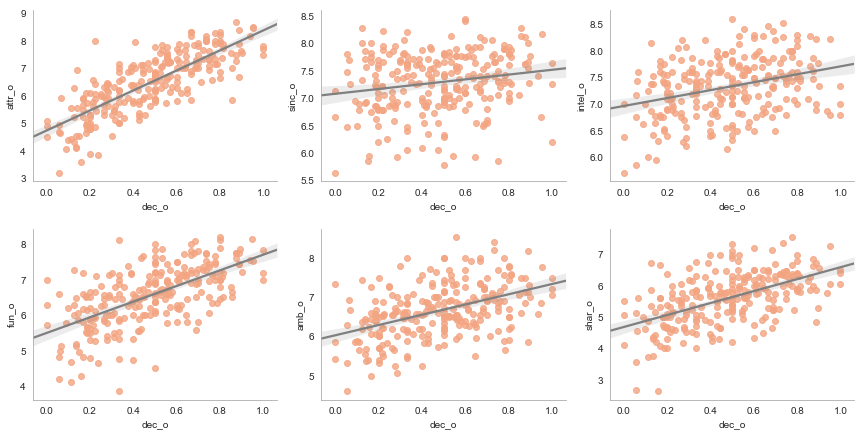

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Regression of percentage of yes decisions for each male against attribute score


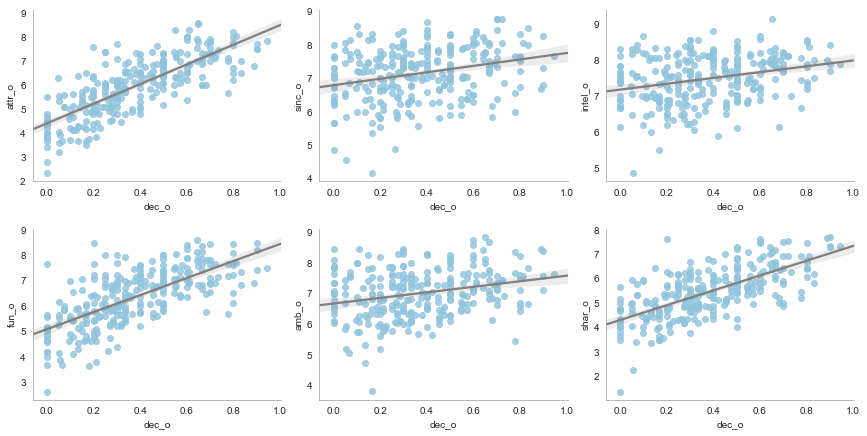

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o
Female,0.789533,0.188686,0.324200,0.618452,0.450832,0.546033
Male,0.776602,0.276619,0.280742,0.685445,0.264554,0.676440


In [81]:
dec_attr_corr_scaled, dec_attr_corr = calc_decision_attr_corr(speed_df)
dec_attr_corr

Above: Correlation tab between % of positive decisions per person and scored attributes. We can see that the strongest correlation was between decision and 1)attractiveness, 2)shared interest, 3)fun.

Below I will compare actual decisions with attribute importances from survey:

In [82]:
def survey_vs_actual_importance(dec_attr_corr_scaled, mean_attr_survey):

    gender = ['Female','Male']
    
    fig, axs = plt.subplots(1,2,figsize = (18,5))
    axs = axs.ravel()
    for g_idx, g in enumerate(gender):

        actual_importance =  dec_attr_corr_scaled.loc[g,:]
        survey_importance =  mean_attr_survey.loc[g,:]
    
        idx_range = range(1,dec_attr_corr_scaled.shape[1]+1)

      
        axs[g_idx].hlines(y = idx_range, xmax = actual_importance, xmin = survey_importance, color = 'grey')
        axs[g_idx].scatter(y = idx_range, x = actual_importance, c = orange)
        axs[g_idx].scatter(y = idx_range, x = survey_importance, c = violet)
        axs[g_idx].set_xlim(0,40)
        
        #changing ticks from default to attribute names 
        ticks = axs[g_idx].get_yticks().tolist()
        ticks_new = ['Attractive', 'Sincere','Intelligent','Fun','Ambitious','Shared interests']
        ticks[1:len(ticks)] = ticks_new
    
        axs[g_idx].set_yticklabels(ticks)
        axs[g_idx].set_xlabel('Relative Importance (scale 0 - 100)')
        axs[g_idx].set_ylabel('Attributes')
        axs[g_idx].set_title('Average difference of attributes\' importance for '+g.lower()+' participants', fontsize = 14)

        blue_patch = mpatches.Patch(color = violet, label='Survey')
        red_patch = mpatches.Patch(color= orange, label='Actual decision')
        axs[g_idx].legend(handles=[blue_patch, red_patch])
        sns.despine()
        
    return plt.show()

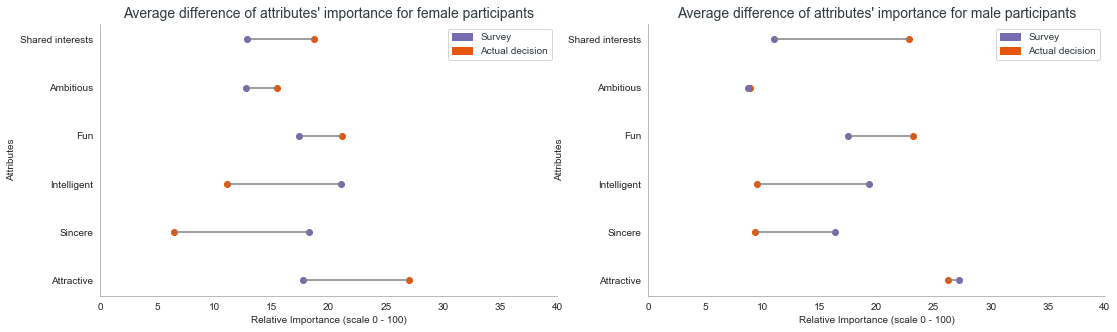

In [83]:
survey_vs_actual_importance(dec_attr_corr_scaled, mean_attrib_survey)

The discrepancies between actual choices and declared importances from the survey are quite high.<br>
Female participants were in fact not looking for a balanced person, but mostly for funny, attractive men with common interests (and being sincere was not so important).<br>
Male participants were right when assessing the importance of attractiveness for their actual decision, but did really poor by underestimating the importance of shared interests and fun and overestimating the importnace of intelligence and sincerity.

### Extensive vs. limited choice - impact on decisions

Were participants in bigger groups during the speed dating experiment more or less willing to give 'yes' decision?

In [84]:
# no of meetings with extended (2) vs limited choice (1)
def ext_lim_choice_summary(speed_df):
    
    speed_df_c = speed_df.copy()
    condtn_mapper ={1:'limited',
                    2:'extensive'
                    } 
    
    speed_df_c['condtn'] = speed_df_c['condtn'].map(condtn_mapper)
    
    ext_lim_counts = speed_df_c['condtn'].value_counts()
    ext_lim_decision = speed_df_c.groupby('condtn')['dec'].agg('mean')
    
    return ext_lim_counts, ext_lim_decision 

In [85]:
ext_lim_counts, ext_lim_decision = ext_lim_choice_summary(speed_df)

In [86]:
print('Number of meetings with extensive or limited choice')
ext_lim_counts

Number of meetings with extensive or limited choice


extensive    6944
limited      1434
Name: condtn, dtype: int64

In [87]:
print('% of yes decision with limited or extensive choice')
pd.DataFrame(ext_lim_decision).style.format('{:.1%}')

% of yes decision with limited or extensive choice


,dec
condtn,
extensive,41.2%
limited,46.0%


We can see that in groups with extensive choice (i.e. groups with more than 24 people) participants were more selective (lower % of yes decision). Now let's see whether this phenomenon affects both genders or only male or female:

In [88]:
def extensive_limited_choice_tab(speed_df, normalize_crosstab = False):
    
    speed_df_gender_gr = speed_df.groupby('gender_dc')
    gender = ['Female','Male']

    crosstabs = {}
    for g in gender:
        
        one_gender_df = speed_df_gender_gr.get_group(g)
        dec_condt_tab = pd.crosstab(columns = one_gender_df['dec'], 
                                    index = one_gender_df['condtn'],
                                    normalize = normalize_crosstab)
        
        dec_condt_tab.index = ['limited', 'extensive']
        dec_condt_tab.columns = ['no','yes']   
        crosstabs[g] = dec_condt_tab
       
    choice_tabs = crosstabs['Female'], crosstabs['Male']
    return choice_tabs


def test_independece_chi(choice_tabs):
    
    choice_test = {}
    gender = ['Female_tab','Male_tab']
    
    for idx, tab in enumerate(choice_tabs):

        chi2, p, _, _ = stats.chi2_contingency(tab)

        results = pd.Series()
        results['CHI2_stat'] = chi2
        results['p-value'] = p
        choice_test[gender[idx]] = results
    
    return pd.DataFrame(choice_test)

In [89]:
female_choice_tab, male_choice_tab = extensive_limited_choice_tab(speed_df, normalize_crosstab = 'index')

In [90]:
print('  Female decisions given limited/extensive number of participants in the speed dating event (normalized by index):')
female_choice_tab.style.format('{:.1%}')

  Female decisions given limited/extensive number of participants in the speed dating event (normalized by index):


,no,yes
limited,56.0%,44.0%
extensive,65.0%,35.0%


In [91]:
print('  Female decisions given limited/extensive number of participants in the speed dating event (normalized by index):')
male_choice_tab.style.format('{:.1%}')

  Female decisions given limited/extensive number of participants in the speed dating event (normalized by index):


,no,yes
limited,51.9%,48.1%
extensive,52.7%,47.3%


In [92]:
#testing for significance:
choice_tabs_counts = extensive_limited_choice_tab(speed_df)
test_independece_chi(choice_tabs_counts)

,Female_tab,Male_tab
CHI2_stat,19.969215,0.112371
p-value,0.000008,0.737461


For female participants, it seems to be important whether they had limited or extensive choice of potential future partners. The dating waves with bigger no. of participants caused women to be more choosy. It is also worth noticing that for male participants it was indifferent whether the group was large or small. It might indicate that woman are more selective than
man when they have an extensive choice (here extensive means more than 12 opposite sex participants)

----------------------------------------

## Classification model

In this part of the analysis I will try to solve binary classification problem: the task is to predict whether each participant of speed dating experiment made 'yes' or 'no' decision ('yes' is considered as sucess: 1 )

From the analysis performed in the previous section we can see that some of the features had significantly different impact on men and women. Therefore I will prepare two separate models for female and male participants and compare results.
In this specific task interpretability of the model is of high importance, so I will focus on logistic regression model. Nevertheless it would be beneficial to perform other classification models to compare outcomes.

#### Feature engineering

I will add age difference between participants - we can check whether it has impacted decision making process

In [93]:
speed_df['age_diff'] = speed_df['age'] - speed_df['age_o']

I wanted to add mn_sat score difference(mn_sat score definition: "Median SAT score for the undergraduate institution where attended. Taken from Barron’s 25th Edition college profile book. Proxy for intelligence"), but the number of null values exceeded 60%, so I dropped it.

#### Choosing features to model

In [94]:
attrib_lst = ['dec', 'gender_dc', 'condtn', 'order', 'int_corr',
              'samerace', 'age_diff', 'field_cd',  'goal', 'date',
              'go_out', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar','exphappy']

Some of the features are numerical, some ordinal and some nominal (dec and gender_dc are not listed below as dec is dependent variable, gender_dc is used to filter men and women).

Nominal variables: 
- field_cd (field of study)
- goal (goal of taking part in speed dating experiment)

Nominal, boolean variables:
- samerace
- condtn (limited or extensive num of partners)

Ordinal variables:
- order (no. of meeting for each participant during speed dating event)
- date (how often goes out for date)
- go_out (how often goes out in general)

Numerical variables:
- exphappy (how happy is participant expect to be during speed dating experiment)
- init_corr (initial correlation between participants interests)
- age_diff
- attr, sinc, intel, fun, amb, shar (rating of speed dating partner)

In [95]:
speed_df_model = speed_df[attrib_lst]
speed_df_model['condtn'] = speed_df_model['condtn'].map({1:0,2:1}) #mapping values from speed dating form to boolean (see documentation)

C:\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [96]:
num_variables = ['exphappy','int_corr','age_diff','attr','sinc','intel','fun','amb','shar']
nominal_variables = ['field_cd','goal']
ord_variables = ['order', 'date', 'go_out']
bool_variables = ['condtn', 'samerace']

#### Checking missing values

In [97]:
pd.DataFrame(np.sum(speed_df_model.isnull(), axis = 0)/len(speed_df_model), columns = ['% of nulls']).style.format('{:.1%}')

,% of nulls
dec,0.0%
gender_dc,0.0%
condtn,0.0%
order,0.0%
int_corr,1.9%
samerace,0.0%
age_diff,2.4%
field_cd,1.0%
goal,0.9%
date,1.2%


#### Split male and female participants decisions, separate target from features and do train test split

 We can do it without loosing any data, since gender_dc had no null values

In [98]:
speed_df_gender = speed_df_model.groupby('gender_dc')
female_df = speed_df_gender.get_group('Female').drop('gender_dc', axis = 1)
male_df = speed_df_gender.get_group('Male').drop('gender_dc', axis = 1)

Xm = male_df.drop('dec', axis = 1)
ym = male_df['dec']

Xf = female_df.drop('dec', axis = 1)
yf = female_df['dec']

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size = 0.3, random_state = 222)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size = 0.3, random_state = 222)

#### Dealing with na's (working on train set): imputing most frequent for categorical variables and median for numerical data


In [99]:
num_imputer = Imputer(strategy = 'median')
cat_imputer = Imputer(strategy = 'most_frequent')

In [100]:
variables_order = nominal_variables + ord_variables + bool_variables + num_variables

variable_order is needed to track which variable has been included in the model and to see its coefficient at the later stage. 

#### Data transformation: imputing nan's, scaling numerical features and encoding categorical data

In [101]:
#preparing data for DataFrameMapper (see sklearn-pandas docs) in the format accepted by sklearn-pandas.DataFrameMapper
nominal_transf = [([var],[cat_imputer, OneHotEncoder()]) for var in nominal_variables]
ord_transf = [([var],[cat_imputer]) for var in ord_variables] 
bool_transf = [([var],[cat_imputer]) for var in bool_variables]
num_transf = [([var],[num_imputer,StandardScaler()]) for var in num_variables]

In [102]:
# putting all transformations together:
var_transf = nominal_transf + ord_transf + bool_transf + num_transf

#building mapper (to be used in Pipeline)
mapper = DataFrameMapper(var_transf)

In [103]:
Xm_train_tr = mapper.fit_transform(Xm_train)

pd.DataFrame(Xm_train_tr).shape

(2935, 38)

In [104]:
#transformed feature names for male participants
transformed_names_male = mapper.transformed_names_

print(transformed_names_male)

['field_cd_0', 'field_cd_1', 'field_cd_2', 'field_cd_3', 'field_cd_4', 'field_cd_5', 'field_cd_6', 'field_cd_7', 'field_cd_8', 'field_cd_9', 'field_cd_10', 'field_cd_11', 'field_cd_12', 'field_cd_13', 'field_cd_14', 'field_cd_15', 'field_cd_16', 'field_cd_17', 'goal_0', 'goal_1', 'goal_2', 'goal_3', 'goal_4', 'goal_5', 'order', 'date', 'go_out', 'condtn', 'samerace', 'exphappy', 'int_corr', 'age_diff', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar']


In [105]:
Xf_train_tr = mapper.fit_transform(Xf_train)

#transformed feature names for female participants
transformed_names_female = mapper.transformed_names_
print(transformed_names_female)

['field_cd_0', 'field_cd_1', 'field_cd_2', 'field_cd_3', 'field_cd_4', 'field_cd_5', 'field_cd_6', 'field_cd_7', 'field_cd_8', 'field_cd_9', 'field_cd_10', 'field_cd_11', 'field_cd_12', 'field_cd_13', 'field_cd_14', 'field_cd_15', 'goal_0', 'goal_1', 'goal_2', 'goal_3', 'goal_4', 'goal_5', 'order', 'date', 'go_out', 'condtn', 'samerace', 'exphappy', 'int_corr', 'age_diff', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar']


#### Preparing pipeline with logistic regression

In [106]:
pipe = Pipeline([('mapper', mapper),
                ('lgreg',LogisticRegression(penalty='l1'))])

grid = GridSearchCV(estimator = pipe,
                    param_grid = {'lgreg__C':[0.0001,0.001,0.01,0.05,0.1,0.5,1,5,10,100]},
                    cv = StratifiedKFold(n_splits=3, shuffle = True),
                    scoring = 'accuracy',
                    return_train_score = True 
                    )

In [107]:
logreg_male_grid = grid.fit(Xm_train, ym_train)

logreg_male_cv_results =  pd.DataFrame(logreg_male_grid.cv_results_)
logreg_male_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_lgreg__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.051371,0.018678,0.519591,0.519591,0.0001,{'lgreg__C': 0.0001},9,0.519918,0.519427,0.519427,0.519673,0.519427,0.519673,0.004993,3.774391e-03,0.000231,0.000116
1,0.052372,0.020015,0.519591,0.519591,0.001,{'lgreg__C': 0.001},9,0.519918,0.519427,0.519427,0.519673,0.519427,0.519673,0.006187,2.831538e-03,0.000231,0.000116
2,0.046699,0.015011,0.745826,0.748213,0.01,{'lgreg__C': 0.01},8,0.750766,0.755624,0.748466,0.758815,0.738241,0.730199,0.002358,1.415516e-03,0.005444,0.012804
3,0.047034,0.016012,0.748893,0.754174,0.05,{'lgreg__C': 0.05},7,0.758938,0.755624,0.740286,0.764946,0.747444,0.741952,0.003562,1.634140e-03,0.007684,0.009443
4,0.056037,0.019684,0.755366,0.760136,0.1,{'lgreg__C': 0.1},1,0.767109,0.760225,0.737219,0.773122,0.761759,0.747062,0.002164,2.057932e-03,0.013014,0.010639
5,0.060376,0.017680,0.753663,0.762862,0.5,{'lgreg__C': 0.5},5,0.769152,0.763292,0.740286,0.770056,0.751534,0.755238,0.009399,1.249019e-03,0.011881,0.006057
6,0.058715,0.017013,0.755026,0.763203,1,{'lgreg__C': 1},2,0.769152,0.762781,0.743354,0.771078,0.752556,0.755749,0.004933,1.415037e-03,0.010677,0.006265
7,0.074052,0.017680,0.755026,0.763714,5,{'lgreg__C': 5},2,0.766088,0.764826,0.742331,0.770567,0.756646,0.755749,0.012337,1.700719e-03,0.009767,0.006101
8,0.101407,0.017674,0.754344,0.763714,10,{'lgreg__C': 10},4,0.765066,0.764826,0.741309,0.770567,0.756646,0.755749,0.033194,3.089123e-03,0.009835,0.006101
9,0.058041,0.015012,0.753322,0.762862,100,{'lgreg__C': 100},6,0.763023,0.764315,0.741309,0.770056,0.755624,0.754216,0.002946,8.104673e-07,0.009014,0.006548


We can see that on cross validation the best result is obtained with C parameter (inverse of regularization strength) set on 0.1, meaning some regularization was needed. I used l1 regularization, because l1 may cause some coefs to be driven down to 0, working as a feature selection (leaving most important features and ousting the least informative). 

Accuracy during cross validation for best model equals 75,5%, which I assess as satisfactory (here we use accuracy as a metric, because independent variable is balanced) 

Let's check the performance of the model on test set:

In [108]:
#defining best model:
logreg_male_model = logreg_male_grid.best_estimator_

logreg_ym_pred = logreg_male_model.predict(Xm_test)
male_acc_pred = accuracy_score(y_pred = logreg_ym_pred, y_true= ym_test)
print('Accuracy of male participants positive decision prediction on test set equals: {0:.1%}'.format(male_acc_pred))

Accuracy of male participants positive decision prediction on test set equals: 75.1%


We can see that accuracy on test set is as good as during cross validation.

Let's see which features left in the model after l1 regularization:

In [109]:
male_coefs_df = pd.DataFrame(logreg_male_model.named_steps['lgreg'].coef_, columns = transformed_names_male)
male_coefs_df = male_coefs_df.loc[:,male_coefs_df.sum() != 0].T
male_coefs_df.columns = ['coefficient_value'] #filtering columns with 0 sum (coef  == 0)

male_coefs_df.sort_values(by='coefficient_value')

,coefficient_value
amb,-0.313335
sinc,-0.192404
field_cd_8,-0.166315
date,-0.062625
exphappy,-0.052614
order,-0.010062
age_diff,0.000473
go_out,0.047322
field_cd_4,0.059747
goal_0,0.189863


Above is the list of features with their coefficients that are used in the logistic regression model with l1 regularization. Not supricingly, we can see that for male participants the most important features were those connected with scoring (attr, shar, etc.). Besides features connected with fequency of dating and going out, order of the meeting, attitude towards speed dating event were also used.    

Now let's move to female dataset:

In [110]:
logreg_female_grid = grid.fit(Xf_train, yf_train)

logreg_female_cv_results =  pd.DataFrame(logreg_female_grid.cv_results_)
logreg_female_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_lgreg__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.058710,0.018012,0.628757,0.628757,0.0001,{'lgreg__C': 0.0001},9,0.628454,0.628908,0.629098,0.628586,0.628718,0.628776,0.003774,3.562162e-03,0.000264,0.000132
1,0.049035,0.018346,0.628757,0.628757,0.001,{'lgreg__C': 0.001},9,0.628454,0.628908,0.629098,0.628586,0.628718,0.628776,0.002946,9.434714e-04,0.000264,0.000132
2,0.052038,0.018346,0.750000,0.746242,0.01,{'lgreg__C': 0.01},8,0.756397,0.746797,0.747951,0.736168,0.745641,0.755760,0.002948,9.457192e-04,0.004624,0.008008
3,0.054371,0.016347,0.750342,0.754952,0.05,{'lgreg__C': 0.05},7,0.742068,0.759610,0.754098,0.746926,0.754872,0.758321,0.002870,1.886212e-03,0.005864,0.005700
4,0.058375,0.016011,0.751708,0.759392,0.1,{'lgreg__C': 0.1},6,0.745138,0.766274,0.756148,0.746926,0.753846,0.764977,0.004192,8.104673e-07,0.004743,0.008831
5,0.055039,0.016018,0.754098,0.761952,0.5,{'lgreg__C': 0.5},1,0.750256,0.758073,0.760246,0.760246,0.751795,0.767537,0.006169,2.170539e-03,0.004392,0.004048
6,0.060043,0.015345,0.752732,0.763488,1,{'lgreg__C': 1},2,0.750256,0.756535,0.758197,0.762295,0.749744,0.771633,0.005720,4.715412e-04,0.003870,0.006221
7,0.094393,0.016685,0.752049,0.764683,5,{'lgreg__C': 5},5,0.748209,0.756023,0.756148,0.763832,0.751795,0.774194,0.015301,1.708933e-03,0.003247,0.007443
8,0.129765,0.018014,0.752391,0.764512,10,{'lgreg__C': 10},3,0.749232,0.756535,0.756148,0.762807,0.751795,0.774194,0.050484,2.160348e-03,0.002855,0.007309
9,0.109410,0.018013,0.752391,0.765195,100,{'lgreg__C': 100},3,0.749232,0.757048,0.756148,0.763832,0.751795,0.774706,0.040898,2.161378e-03,0.002855,0.007273


In [111]:
#defining best model:
logreg_female_model = logreg_female_grid.best_estimator_

logreg_yf_pred = logreg_female_model.predict(Xf_test)
male_acc_pred = accuracy_score(y_pred = logreg_yf_pred, y_true= yf_test)
print('Accuracy of male participants positive decision prediction on test set equals: {0:.1%}'.format(male_acc_pred))

Accuracy of male participants positive decision prediction on test set equals: 76.0%


In [112]:
female_coefs_df = pd.DataFrame(logreg_female_model.named_steps['lgreg'].coef_, columns = transformed_names_female)
female_coefs_df = female_coefs_df.loc[:,female_coefs_df.sum() != 0].T
female_coefs_df.columns = ['coefficient_value'] #filtering columns with 0 sum (coef  == 0)

female_coefs_df.sort_values(by='coefficient_value')

,coefficient_value
field_cd_1,-1.268586
condtn,-0.513038
goal_5,-0.501240
field_cd_11,-0.340444
field_cd_9,-0.319125
field_cd_7,-0.287558
amb,-0.234822
field_cd_0,-0.233346
goal_0,-0.160068
field_cd_10,-0.132097


List of the features is longer for female participants than for male. We can observe that many different fields of studies are included, whereas in the model for male participants only few fields were taken into account. Features connected with scoring (attr, sinc etc.) were also used in the model. Extensive or limited choice is for female also of high importance (condtn variable). Besides, similarly to male participants: going out or frequency of dating also impact willingness to give 'yes' decision.

--------------------------------------------

### Summary

Analysis performed on speed dating dataset gave some insight into decision making process of its participants. As stated at the very beginng, I would be very cautious while generalizing outcomes from this particural analysis to the whole population of people looking for a partner. Nevertheless here are some most interesting (at least for me) conculsions:

- Female participants show same race preference while choosing partner.
- Extensive or limited choice of potential partner affected women decisions: with bigger group they were more selective. For male this effect did not occur.
- Order of meeting affects participant decision: the later the meeting the lower the chance for 'yes' decision
- Average participant is optimist: he/she rates himself/herself higher in every category than speed dating counterparty rates him/her (this gap between self-esteem and rating is the biggest while assessing participant's intelligence).
- Both male and female participants were looking for attractive, funny partner with simmilar interests. Other features like sincerity, intelligence or ambition were less importnat while making 'yes' decision.
- Male and female participants were inconsistent and did not stick to what they have declared as important during survey before speed dating event.
- Performing simple logistic regression models to predict 'yes' decisions made by men and women participants performed well, achieving accuracy at the level of ca. 75% 